In [ ]:
# # Подгружаем данные в ~/Desktop, чтобы не менять ссылку в коде
# !cd ~/Desktop
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IpNZQfchwcGRGZdhbXU4ynpD9py5TDrh' -O data.csv

In [1]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, \
GradientBoostingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, RobustScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from scipy.sparse import hstack
from tqdm import tqdm

from catboost import CatBoostRegressor, Pool, cv, FeaturesData
from xgboost import XGBRegressor

%matplotlib inline

In [2]:
pd.set_option('display.max_columns',50)

In [3]:
# собираем DataFrame из скачанных данных (берем последний json, так как в нем максимальное количество собранной
# информации)
# собирается долго - около 2 часов
# после первой сборки - этот блок не нужен

# data = pd.DataFrame()
# files = os.listdir('../../../Desktop/data/')
# with open('../../../Desktop/data/' + files[-1], 'r') as f:
#     new_dict = {}
#     new_dict = json.loads(f.read(), encoding='mac_cyrillic')
#     df = pd.DataFrame()
#     i = 0
#     for key, val in tqdm(new_dict.items()):
#         df.loc[i,'link'] = key
#         for k, v in val.items():
#             df.loc[i,k] = v
#         i += 1
#     data = pd.concat([data, df])

In [4]:
# сохраняем собранный датасет на диск - чтобы каждый раз не собирать по 2 часа 
# data.to_csv('~/Desktop/data.csv')

In [5]:
# считываем данные, сохраненные на прошлом шаге (так как уже все собрано - начинаем сразу отсюда)
data = pd.read_csv('~/Desktop/data.csv', index_col=0, encoding='utf-8')

In [6]:
# cмотрим на пропуски в полях
data.isna().sum()

link                    0
year                 2208
kmAge                2554
bodytype             2218
color                2208
engine               2210
transportTax        24268
transmission         2419
drive                2575
wheel                2554
state                2554
ownersCount          2717
pts                  2704
owningTime          57226
customs              2554
vin                  4640
licensePlate        21763
model_name          20956
price               20956
price_change        90187
publication_date     2208
views                2554
photo_count          2208
official_dealer     87679
dtype: int64

In [7]:
# убираем те поля, где слишком много пропусков

data.drop(['transportTax','owningTime', 'licensePlate','price_change', 'official_dealer'], axis=1, inplace=True)

In [8]:
data.dropna(inplace=True)

In [9]:
# убираем редкие данные, которые портят в итоге модель

data.drop(data[data.state!='Не требует ремонта'].index, inplace=True)

In [10]:
data.drop(data[data.wheel=='Правый'].index, inplace=True)

In [11]:
# test_df = pd.read_csv('~/Downloads/test.csv')

### Предобработка данных

In [281]:
# обрабатываем столбцы датасета. Если данных нет - возвращаем None

# переводим год в числовой формат (везде float для catboost FeaturesData)
def get_car_type(link_row):
    return link_row.split('/')[3]

def to_int_year(year_row):
    return float(year_row)

# переводим километраж в числовой формат
def to_int_km(kmAge_row):
    if not kmAge_row:
        return None
    regex = re.compile('\d+')
    cleaned_row = ''.join(regex.findall(kmAge_row)[0])
    return float(cleaned_row)

def fix_views(views_row):
    if '№' in views_row:
        return None
    regex = re.compile('\d+')
    cleaned_row = float(regex.search(views_row)[0])
    return cleaned_row

# разбиваем на 3 колонки информацию по двигателю (объем, мощность в л.с. и тип топлива)
def split_engine_col(engine_row):
    volume = None
    horse_power = None
    fuel_type = None
    if engine_row == None:
        return volume, horse_power, fuel_type
    
    params = engine_row.split('/')
    params_num = len(params)
    for p in params:
        if ('бензин' in p.lower()) or ('дизел' in p.lower()) or ('газ' in p.lower()):
            fuel_type = p
        if 'л.' in p.lower():
            regex = re.compile('\d+')
            horse_power = float(''.join(regex.findall(p)))
        if ' л' in p:
            regex = re.compile('\d+\.\d+')
            volume = float(''.join(regex.findall(p)))
    return [volume, horse_power, fuel_type]

# корректируем 'кракозябры' в птс
def fix_pts(pts_row):
    pts_list = ['Оригинал', 'Дубликат']
    if pts_row not in pts_list:
        return 'Оригинал'
    return 'Оригинал'

# достаем число владельцев
def fix_ownersCount(ownersCount_row):
    owners_list = ['3 или более', '2 владельца', '1 владелец']
    if not ownersCount_row:
        return None
    if ownersCount_row.replace('\xa0', ' ') not in owners_list:
        ownersCount_row = '3 или более'
    return float(ownersCount_row[0])

# общая функция для очистки данных от неправильного кодирования
def fix_bad_encoding(row):
    if not row:
        return None
    if 'Ð' in row:
        return None
    return row

# очищаем цену от байтовых разделителей (где-то нужно было с кодировкой поработать, но - поезд ушел :) )
def fix_price(price_row):
    try:
        return float(price_row[:-1].replace('\xa0', ''))
    except:
        return None

# расчет транспортного налога - в итоге не нужно
def count_transport_tax(engine_hp_row):
    if engine_hp_row <100:
        return engine_hp_row*25
    elif engine_hp_row <150:
        return engine_hp_row*35
    elif engine_hp_row <200:
        return engine_hp_row*50
    elif engine_hp_row <250:
        return engine_hp_row*75
    else:
        return engine_hp_row*150

# переводим дату публикации в формат unix-timestamp
def calculate_publ_date(publication_date):
    month_dict = {
        'января' : '01',
        'февраля' : '02',
        'марта' : '03',
        'апреля' : '04',
        'мая' : '05',
        'июня' : '06',
        'июля' : '07',
        'августа' : '08',
        'сентября' : '09',
        'октября' : '10',
        'ноября' : '11',
        'декабря' : '12',
    }
    
    i = 1
    for key in month_dict:
        if key in publication_date:
            break
        i += 1
        if i > 12:
            return None
    regex = re.compile('\d{4}')
    year_match = regex.search(publication_date)
    if not year_match:
        year = ' 2020'
        publication_date = publication_date + year
    
    for key in month_dict:
        if key in publication_date:
            pub_date = publication_date.replace(key, month_dict[key])    
    date = datetime.strptime(pub_date, '%d %m %Y').timestamp()
    return date

# достаем название бренда, модели и модификации из поля model_name
def split_brand_model(model_row):
    fix_list = [
    '«Чайка»',
    '«Волга»',
    'Siber',
    '«Победа»',
    'Defender',
    'Discovery',
    'Freelander',
    'Range Rover',
    'Granta',
    'Kalina',
    'Largus',
    'Priora',
    'Vesta',
    'Vitara',
    'Picasso',
    'Cherokee',
    'Series',
    'WRX',
    'Lancaster',
    '(ВАЗ)',
    ]
    brand, model, modif = model_row.split()[0].strip(), model_row.split()[1].strip(), ' '.join(model_row.split()[2:])
    if brand == 'Land':
        brand += ' Rover'
        model = model.replace('Rover', '').strip()
    
    modif = modif.strip()
    for part in fix_list:
        if part in modif:
            modif = modif.replace(part, '').strip()
            model = (model + ' ' + part).strip()
    return [brand, model, modif]

def fix_vin(vin_row):
    if not vin_row:
        return 'other'
    return vin_row.replace('*', '')

# # достаем номер региона рег номера - поле далее убрано, ухудшает метрики данных
# def fix_license_plate(licensePlate_row):
#     if not licensePlate_row:
#         return None
#     return licensePlate_row.split('|')[1]

# функция, суммирующая все предыдущие
def clear_data(data_df):
    data_new = pd.DataFrame()
    
    data_new['car_type'] = data_df['link'].map(get_car_type)
    data_new['year'] = data_df['year'].apply(to_int_year)
    data_new['kmAge'] = data_df['kmAge'].apply(to_int_km)
    
    # гипотеза, что убывающие функции по году и пробегу сработала - добавляем поля
#     data_new['inv_year'] = np.exp(-0.48*data_df['year'].apply(to_int_year))
#     data_new['inv_kmAge'] = np.exp(-0.48*data_df['kmAge'].apply(to_int_km))

    data_new['inv_year'] = -np.log(data_df['year'].apply(to_int_year))
    data_new['inv_kmAge'] = -np.log(data_df['kmAge'].apply(to_int_km))

    data_new['drive'] = data_df['drive']
    data_new['bodytype'] = data_df['bodytype'].apply(fix_bad_encoding)
    data_new['color'] = data_df['color'].apply(fix_bad_encoding)
    
    # делаем сразу 3 поля
    engine_data = pd.DataFrame(data_df['engine'].apply(split_engine_col).tolist(), 
                               columns=['engine_vol','engine_hp','engine_fuel'],
                               index=data_df.index)
    data_new = pd.concat([data_new, engine_data], axis=1)
    
    data_new['transport_tax'] = data_new['engine_hp'].apply(count_transport_tax)
    
    data_new['transmission'] = data_df['transmission'].apply(fix_bad_encoding)
    data_new['ownersCount'] = data_df['ownersCount'].apply(fix_ownersCount)
    data_new['model_name'] = data_df['model_name'].apply(fix_bad_encoding)
    data_new['price'] = data_df['price'].apply(fix_price)
    data_new['publication_date'] = data_df['publication_date'].apply(calculate_publ_date)
    
    data_new['vin'] = data_df['vin'].apply(fix_vin)
    data_new['pts'] = data_df['pts'].apply(fix_pts)
    
    data_new['photo_count'] = data_df['photo_count']
    not_na_cols = ['year', 'kmAge', 'model_name', 'price']
    
    # делаем сразу 3 поля
    brand_model = pd.DataFrame(data_df['model_name'].apply(split_brand_model).tolist(), 
                               columns=['brand','model','modification'],
                               index=data_df.index)
    data_new = pd.concat([data_new, brand_model], axis=1)
    data_new['km_per_year'] = data_new['kmAge']/(2020 - data_new['year'].apply(lambda x: x if x!=2020 else 2019))
    data_new['km_per_owner'] = data_new['kmAge']/data_new['ownersCount']
    data_new['publ_since'] = datetime.timestamp(datetime.now()) - data_new['publication_date']
    data_new[['engine_vol', 'engine_hp']].fillna(data_new[['engine_vol', 'engine_hp']].mean(), inplace=True)
    data_new['hp_per_vol'] = data_new['engine_hp']/data_new['engine_vol']
    data_new['views'] = data_df['views'].apply(fix_views)
 
    data_new.dropna(subset=not_na_cols, inplace=True)
    data_new.drop(data_new[data_new['photo_count']<4].index, inplace=True)
    return data_new

In [282]:
# очищенный датасет
final_data = clear_data(data).dropna()

/Users/maksim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [283]:
# числовые и категориальные столбцы

num_features = [
                'year', 
                'kmAge',
                'inv_year',
                'inv_kmAge',
                'engine_vol', 
                'engine_hp',
                'ownersCount',
                'publication_date', 
                'photo_count', 
                'km_per_year', 
#                 'km_per_owner', # - портит модель
                'publ_since', 
                'hp_per_vol', 
                'views'
               ]

cat_features = ['car_type', 
                'bodytype', 
                'color', 
                'drive',
                'engine_fuel', 
                'transmission', 
                'brand',
                'model',
                'model_name',
                'modification',
                'pts',
                'vin',
               ]


# выделяем признаки
X = final_data.drop(['price'], axis=1)
# считаем средние значения и самые частотные значения для числовых и категориальных данных
# numeric_features_mean = final_data[numeric_features].mean().astype('float32')
# cat_features_mostfreq = final_data[cat_features].mode(0).iloc[0]

# заполняем пустоты средними значениями для числовых данных
# заполняем пустоты наиболее частотными значениями для категориальных данных

# выделяем target
y = final_data.price

In [284]:
# ищем индексы выбросов для каждой колонки

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return ys[(ys > upper_bound) | (ys < lower_bound)].index

# объединяем индексы
outliers_index_list = []
columns = list(X[num_features].columns)
for col in columns:
    outliers_idx = outliers_iqr(final_data[col])
    outliers_index_list += list(outliers_idx)

In [285]:
# ручная чистка от выбросов - решения sklern типа DBScan, Isolated tree и др не дали хороших результатов


# находим индексы раритетных авто
# year_outliers_indx = list(X.year[X.year < 1980.0].index)

# находим индексы выбросов с очень большим пробегом
kmAge_peaks_indx = list(X.kmAge[X.kmAge > 80e4].index)

# убираем редкие нецелевые виды кузова
bodytype_names = X.bodytype.value_counts().iloc[12:].index
bodytype_outliers = ['тент', 'промтоварный автофургон', 'изотермический фургон',
       'рефрижератор', 'бортовой грузовик',
       'купе-хардтоп', 'внедорожник открытый', 'эвакуатор',
       'фургон для торговли', 'скорая помощь',
       'кэмпер', 'микровэн', 'тарга', 'седан-хардтоп',
       'шасси', 'самосвал', 'лимузин', 'цистерна',
       'самосвал с 2-х разгрузкой',
        'цельнометаллический фургон',
        'пикап одинарная кабина', 'пикап', 'родстер']

bodytype_outliers_index = list(X[X.bodytype.isin(bodytype_outliers)].index)

# rare_model_index = list(Xy.model_name[Xy.model_name.map(Xy.model_name.value_counts())<4].index)

# находим индексы выбросов по объему двигателя
engine_hp_outliers_indx = list(X.engine_hp[(X.engine_hp < 50) | (X.engine_hp > 1500)].index)

# находим индексы очень редких видов топлива
engine_fuel_outliers = list(X.engine_fuel.value_counts().iloc[2:].index)
engine_fuel_outliers_index = list(X[X.engine_fuel.isin(engine_fuel_outliers)].index)

# находим индексы ошибочных объемов
engine_vol_outliers_indx = list(X.engine_vol[(X.engine_vol > 7.0) | (X.engine_vol < 0.5)].index)

# находим устаревший редкий термин трансмиссии - видимо старая категория на авто.ру
transmission_outliers_indx = list(X.transmission[X.transmission == 'робот'].index)

# ошибочная цена в 68 000 000 за какой-то Форд Куга...
price_outliers_index = list(y[(y>3e7)].index)# | (y<1e5)].index)

# публикации, которые были сделаны до 2016 года - тоже убираем
pub_date_outliers_index = list(X[X.publication_date < 1451595600.0].index)

drive_outliers_index = list(final_data[final_data.drive.isin(['полный подключаемый', 
                                          'заднеприводный с подключаемым передним',
                                          'постоянный привод на все колеса'])].index)

# vin_outliers_index = list(X_cleaned[X_cleaned['vin'].map(X_cleaned.vin.value_counts()<10)==True].index)

# суммируем все индексы
outliers_indx = list(set(bodytype_outliers_index + transmission_outliers_indx + engine_hp_outliers_indx +
                        price_outliers_index + engine_fuel_outliers_index + engine_vol_outliers_indx + 
                        pub_date_outliers_index  + outliers_index_list + engine_vol_outliers_indx + 
                        kmAge_peaks_indx)) #+ vin_outliers_index))

# итогам первых прогонов - поля ниже - портят данные, без них метрики лучше
# вычищаем все данные с индексами = outlier index
X_cleaned = X.drop(outliers_indx)

# вычищаем все данные с индексами = outlier index

# логарифмируем target - лучшие показатели именно на логарифме
y_cleaned = y.drop(outliers_indx).apply(np.log)

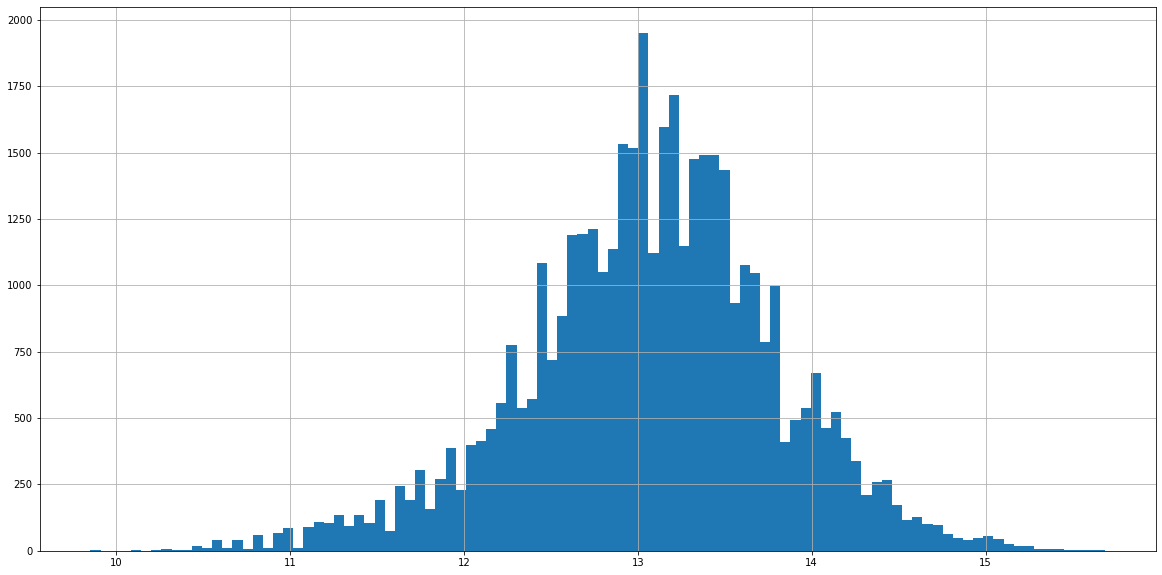

In [286]:
# target после логарифмирования - "купол" и совсем другие данные по MAPE
fig, ax = plt.subplots(figsize=(20, 10))
y_cleaned.hist(bins=100)

### Обработка категориальных признаков через mean/count encoding

In [287]:
def make_price_mean_count(df_mean_train, df_mean_test, col, df_train, df_test, group_cols=None):
    
    # функция добавляет в df_mean_train и df_mean_test столбцы средней цены/количества объявлений
    # для каждого категориального признака col. group_cols - лист с дополнительными признаками,
    # которые позволяют группировать цены/количества объявлений по связке "признаки group_cols + признак col"
    
    join_cols = []
    
    if (group_cols!=None) and (col not in group_cols):
        join_cols.append(col) 
        join_cols += group_cols
    else:
        join_cols.append(col)
    
    df_mean_train[col+'_price_mean'] = df_train[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                                 price.median(), on=join_cols, how='left').iloc[:,-1]
    df_mean_test[col+'_price_mean'] = df_test[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                               price.median(), on=join_cols, how='left').iloc[:,-1]
    df_mean_train[col+'_count'] = df_train[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                            price.count(), on=join_cols, how='left').iloc[:,-1]
    df_mean_test[col+'_count'] = df_test[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                          price.count(), on=join_cols, how='left').iloc[:,-1]   
    
    if col == 'model': 
        df_mean_test[col+'_price_mean'] = df_mean_test[col+'_price_mean'].\
        fillna(df_mean_test['brand_price_mean']) 
        
        df_mean_test[col+'_count'] = df_mean_test[col+'_count'].\
        fillna(df_mean_test['brand_count'])
    
    if col == 'model_name':
        df_mean_test[col+'_price_mean'] = df_mean_test[col+'_price_mean'].\
        fillna(df_mean_test['model_price_mean']).\
        fillna(df_mean_test['brand_price_mean'])    
        
        df_mean_test[col+'_count'] = df_mean_test[col+'_count'].\
        fillna(df_mean_test['model_count']).\
        fillna(df_mean_test['brand_count'])  
    
    if col == 'modification':
        df_mean_test[col+'_price_mean'] = df_mean_test[col+'_price_mean'].\
        fillna(df_mean_test['model_name_price_mean']).fillna(df_mean_test['model_price_mean']).\
        fillna(df_mean_test['brand_price_mean'])    
        
        df_mean_test[col+'_count'] = df_mean_test[col+'_count'].\
        fillna(df_mean_test['model_name_count']).fillna(df_mean_test['model_count']).\
        fillna(df_mean_test['brand_count'])
        
        
    other_filler_price_mean = df_mean_test[f'{col}_price_mean'].median()
    df_mean_test[f'{col}_price_mean'] = df_mean_test[f'{col}_price_mean'].fillna(other_filler_price_mean)

    other_filler_count = df_mean_test[f'{col}_count'].median()
    df_mean_test[f'{col}_count'] = df_mean_test[f'{col}_count'].fillna(other_filler_count)



def make_num_feat_mean(df_mean_train, df_mean_test, col, num_col, df_train, df_test, group_cols=None):
    
    # аналогичная функция, но кодирует категориальные признаки по средним значениям числовых колонок (num_features)
    
    if col in ['brand', 'model', 'model_name']:
        join_cols = []

        if (group_cols!=None) and (col not in group_cols):
            join_cols.append(col) 
            join_cols += group_cols
        else:
            join_cols.append(col)

        df_mean_train[f'{col}_{num_col}_mean'] = df_train[join_cols].merge(df_train.groupby(by=join_cols, as_index=False)\
                                                               [num_col].mean(), on=join_cols, how='left').iloc[:,-1]

        df_mean_test[f'{col}_{num_col}_mean'] = df_test[join_cols].merge(df_train.groupby(by=join_cols, as_index=False)\
                                                               [num_col].mean(), on=join_cols, how='left').iloc[:,-1]

        if col == 'model': 
            df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].\
            fillna(df_mean_test[f'brand_{num_col}_mean']) 

        if col == 'model_name':
            df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].\
            fillna(df_mean_test[f'model_{num_col}_mean']).\
            fillna(df_mean_test[f'brand_{num_col}_mean'])    

        if col == 'modification':
            df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].\
            fillna(df_mean_test[f'model_name_{num_col}_mean']).fillna(df_mean_test[f'model_{num_col}_mean']).\
            fillna(df_mean_test[f'brand_{num_col}_mean'])    

        other_filler = df_mean_test[f'{col}_{num_col}_mean'].median()
        df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].fillna(other_filler)


In [288]:
# для обучения брал выборки в 5-10%
X_cleaned_sample = X_cleaned.sample(frac=0.99, random_state=42)
y_cleaned_sample = y_cleaned.sample(frac=0.99, random_state=42)

encoder = OneHotEncoder()
poly = PolynomialFeatures() # PolyFeatures не помогают, как показала практика

X_poly = poly.fit_transform(X_cleaned_sample[num_features])

X_num = X_cleaned_sample[num_features]

# OHE для категориальных данных - плохо работают
# main_cat_features = cat_features[4:7]
# X_cat_ohe = encoder.fit_transform(X_cleaned_sample[main_cat_features])

# polyfeatures работают плохо - не используем
# X = hstack((X_num, X_cat_ohe))

X = X_num

In [289]:
# хотел сделать через cross_val - но target нужно вытаскивать из логарифма, поэтому scoring получается кастомный
# как сделать cross_val на кастомном scoring - пока не умею
# поэтому делаем православный train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cleaned_sample, 
                                                    test_size=0.3, shuffle=True, random_state=42)

In [290]:
# получаем индексы train и test выборок
train_idx = y_train.index.values
test_idx = y_test.index.values

# добавляем таргет и получаем 2 выборки "признак=таргет"
df_train = pd.concat([X_cleaned_sample, y_cleaned_sample], axis=1).loc[train_idx]
df_test = pd.concat([X_cleaned_sample, y_cleaned_sample], axis=1).loc[test_idx]

# пустые фреймы для mean/count encoding features
df_mean_train = pd.DataFrame()
df_mean_test = pd.DataFrame()

# создаем кодированные категориальные признаки
for col in cat_features:
    make_price_mean_count(df_mean_train, df_mean_test, col, df_train, df_test, group_cols=None)
    for num_col in num_features[:3]:
        make_num_feat_mean(df_mean_train, df_mean_test, col, num_col, df_train, df_test, group_cols=['brand'])
        
mean_columns = df_mean_test.columns

# если стэковать OHE, то нужна scipy.sparse.hstack, 
# если OHE не использовать - то стыковка через np.hstack
if 'sparse' in str(type(X_train)):
    X_train = hstack([X_train, df_mean_train])
    X_test = hstack([X_test, df_mean_test])
else:
    X_train = np.hstack([X_train, df_mean_train])
    X_test = np.hstack([X_test, df_mean_test])

# скелим данные для линейных методов
scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### Моделирование

In [320]:
# Пробуем блендинг

ests = {
'cat': CatBoostRegressor(depth=7, iterations=10000, learning_rate=0.03, verbose=False, random_state=42),
'xgb' : XGBRegressor(n_estimators=10000, max_depth=3, learning_rate=0.05, random_state=42),
'gb' : GradientBoostingRegressor(n_estimators=5000, max_depth=3, learning_rate=0.07, random_state=42),
}
    
y_pred_dict = {}
mape_dict = {}
for est in ests:
    ests[est].fit(X_train, y_train)
    y_pred = ests[est].predict(X_test)
    y_pred_dict.update({est:y_pred})

    # считаем словарь эстиматор-mape, восстанавливая target из логарифма
    mape = (abs(np.exp(y_pred) - np.exp(y_test))/np.exp(y_test)).mean()
    mape_dict.update({est:mape})

# Catboost можно использовать с помощью FeaturesData/Pool - с моим неумением тюнить CatBoost разницы не увидел

# X_cleaned_sample = X_cleaned.sample(frac=0.99, random_state=42)
# y_cleaned_sample = y_cleaned.sample(frac=0.99, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_cleaned_sample, y_cleaned_sample, test_size=0.3, shuffle=True)

# X_train_fd = FeaturesData(num_feature_data=X_train[numeric_features].values, 
#                           cat_feature_data=X_train[cat_features].values,
#                           num_feature_names=numeric_features,
#                           cat_feature_names=cat_features)
# X_test_fd = FeaturesData(num_feature_data=X_test[numeric_features].values, 
#                          cat_feature_data=X_test[cat_features].values,
#                          num_feature_names=numeric_features,
#                          cat_feature_names=cat_features)
# X_train_pool = Pool(data=X_train_fd, label=y_train)
# X_test_pool = Pool(data=X_test_fd, label=y_test)

# cb.fit(X_train_pool)
# y_pred = cb.predict(X_test_pool)
# (abs(np.exp(y_pred) - np.exp(y_test))/np.exp(y_test)).mean()

In [321]:
mape_dict

{'cat': 0.08731439284984108,
 'xgb': 0.08995599203531122,
 'gb': 0.08994130906011347}

In [322]:
# делаем фрейм из предиктов моделей
y_pred_df = pd.DataFrame(y_pred_dict)

In [323]:
# добавляем среднее значение
y_pred_df['pred_mean'] = y_pred_df.mean(axis=1)

In [324]:
y_pred_blend = y_pred_df['pred_mean'].values

In [325]:
mape_blend = (abs(np.exp(y_pred_blend) - np.exp(y_test))/np.exp(y_test)).mean()

In [327]:
# Пробуем стекинг

regressors = [
    ('GBR', GradientBoostingRegressor(n_estimators=5000, max_depth=3, learning_rate=0.07, random_state=42)),
    ('CATB', CatBoostRegressor(depth=7, iterations=10000, learning_rate=0.03, verbose=False, random_state=42)),
]

final_estimator = Ridge(alpha=50, max_iter=10000)
# final_estimator = SVR(C=0.5)
# final_estimator = XGBRegressor(n_estimators=200, max_depth=3, random_state=42)

stack_regr = StackingRegressor(estimators=regressors, final_estimator=final_estimator)

stack_regr.fit(X_train, y_train)
y_pred = stack_regr.predict(X_test)

# считаем наш кастомный mape, восстанавливая target из логарифма
mape_stack = (abs(np.exp(y_pred) - np.exp(y_test))/np.exp(y_test)).mean()

### Результат

In [328]:
print(f'Blending MAPE = {mape_blending}')
print(f'Stacking MAPE = {mape_stack}')

Blending MAPE = 0.09045728421366735
Stacking MAPE = 0.08735584783035397


In [ ]:
# Опционально можно посмотреть feature importances

# importances = stack_regr.estimators_[2].feature_importances_
# # encoded_features = encoder.get_feature_names()
# # columns = numeric_features + list(encoded_features) + list(mean_columns)
# columns = num_features + list(mean_columns) #+ list(encoder.get_feature_names()) 
# len(importances) - len(columns)

In [ ]:
# df = pd.DataFrame({'cols':columns, 'val':importances}).sort_values('val', ascending=False)
# df

### ДОПОЛНЕНИЯ

In [ ]:
# Можно запустить Catboost через Pool - в целом тот же результат
# Сделал проверку MAPE xthtp

In [ ]:
X_cleaned_sample = X_cleaned.sample(frac=0.99, random_state=42)
y_cleaned_sample = y_cleaned.sample(frac=0.99, random_state=42)

X_cleaned_fd = FeaturesData(num_feature_data=X_cleaned_sample[numeric_features].values, 
                    cat_feature_data = X_cleaned_sample[cat_features].values,
                    num_feature_names = numeric_features,
                    cat_feature_names = cat_features)


data_pool = Pool(data=X_cleaned_fd, label=y_cleaned_sample)
reg = CatBoostRegressor()

# Опять же - можено нельзя поставить кастомный scoring (или можно - но не знаю как)
params = {"iterations": 10000,
          "depth": 7,
          "learning_rate": 0.045,
          "loss_function": "MAE",
          "verbose": False}

In [ ]:
scores = cv(data_pool,
            params,
            fold_count=3, 
            plot="True")

In [ ]:
# проверка других моделей на кроссвалидации на встроенном MAE (который ввиду логарифмироания не имеет никакого
# физического смысла, но уменьшать его можно)

In [ ]:
# оооочень долго учится лес. Невыносимо, часа 4-5 на 10 000 деревьев
regressor = RandomForestRegressor(random_state=42)
params = {
    'n_estimators' : [5000],# 10000],
    'max_depth' : [30],
    'criterion' : ['mse']
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# почему-то учится еще дольше, чем лес
regressor = ExtraTreesRegressor(random_state=42)
params = {
    'n_estimators' : [300, 1000],# 5000],
    'max_depth' : [100],
    'criterion' : ['mae']
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# на удивления помогли деревья нестандартной глубины (глубина 7 работает лучше чем дефолтная 3) и нужно
# много деревьев - 10 000 - лучший cross-val
regressor = CatBoostRegressor()
params = {'depth':[3, 6, 7, 8],
          'iterations':[10000, 15000, 20000],
          'learning_rate':[0.05, 0.07, 0.1]}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# долго и результат хуже, чем у Catboost

regressor = GradientBoostingRegressor(random_state=42)
params = {
    'n_estimators' : [2000],
    'max_depth' : [3],
    'learning_rate' : [0.1, 0.2]
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# Результат как у регрессий, но на больших данных SVR закончит вычисления "никогда" на моем ноутбуке

regressor = SVR()
params = {
    'C': [0.25],
    'kernel': ['linear'],
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# очень быстро, но результат хуже, чем у CatBoost - 0.155 против 0.125

regressor = Lasso()
params = {
    'alpha': [7e-5]
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# результат чуть хуже, чем у Lasso

regressor = Ridge()
params = {
    'alpha': [1.5]
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# Слабее Lasso, Ridge

regressor = LinearRegression()
params = {
    'fit_intercept': [True, False]
}

gs = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
gs.fit(X, y_cleaned_sample)

print(gs.best_params_)
print(f'MAE = {-gs.best_score_}')

In [ ]:
# записал рзультаты эстиматоров на кросс-валидации по MAE по логарифмированному target

In [ ]:
""""
Random Forest
{'criterion': 'mse', 'max_depth': 30, 'n_estimators': 5000}
MAE = 0.18613126948166414

Extra Trees
{'criterion': 'mae', 'max_depth': 100, 'n_estimators': 50}
MAE = 0.17843565781992193

Linear Regression
{'fit_intercept': True}
MAE = 0.16166042820598073

Ridge
{'alpha': 2}
MAE = 0.1549745451687659

Lasso
{'alpha': 7e-05}
MAE = 0.15383390684128465

SVR
{'C': 0.25, 'kernel': 'linear'}
MAE = 0.15392866099694105

GradientBoost
{'max_depth': 5, 'n_estimators': 500}
MAE = 0.1667841712619347

In [ ]:
# пробовал стекинг - результат хуже, чем у отдельных моделей. 

In [ ]:
regressors = [
    ('Ridge', Ridge(alpha=1.5)),
    ('Lasso', Lasso(alpha=2)),
    ('Linear', LinearRegression())
]
final_estimator = CatBoostRegressor(depth=7, iterations=10000, learning_rate=0.1)
# final_estimator = RandomForestRegressor(max_depth=30, n_estimators=5000)
# final_estimator = GradientBoostingRegressor(max_depth=7, n_estimators=2000)

In [ ]:
stack_regr = StackingRegressor(estimators=regressors, final_estimator=final_estimator, 
                                             cv=5, n_jobs=-1)
mae = cross_val_score(estimator=stack_regr, X=X, y=y_cleaned_sample, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)